In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import stats
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
sns.set(style="whitegrid", color_codes=True)
plt.rcParams['figure.figsize'] = (12, 12)

In [2]:
def preprocess_spectra(df):
    df = average_dataframe(df, 15).transpose()
    nm = [str(int(x)) for x in df.iloc[0]]
    df = df.drop("Wavelengths", 0)
    df.columns = nm
    df = pd.concat([base, df], axis=1)
    return df

def average_dataframe(df, n):
    # Separate label column from data
    label = df.iloc[:,0]
    df = df.iloc[:,1:]

    if (df.shape[1]) % n != 0:
        raise Exception("Number of columns: {}. Not divisible by {}.".format(df.shape[1], n))

    # Average every N columns
    average_df = pd.DataFrame()
    average_df["Wavelengths"] = label
    for i in range((df.shape[1]) // n):
        average_df[i] = df.iloc[:,i*n:(i+1)*n].mean(axis=1)

    return average_df

In [3]:
gt_10_20 = pd.read_csv("../data/Spreadsheet/Lettuce/2017-10-20.csv").dropna().drop("Plant Number", 1)
gt_10_27 = pd.read_csv("../data/Spreadsheet/Lettuce/2017-10-27.csv").dropna().drop("Plant Number", 1)
gt_11_03 = pd.read_csv("../data/Spreadsheet/Lettuce/2017-11-03.csv").dropna().drop("Plant Number", 1)
gt_11_10 = pd.read_csv("../data/Spreadsheet/Lettuce/2017-11-10.csv").dropna().drop("Plant Number", 1)
gt_11_17 = pd.read_csv("../data/Spreadsheet/Lettuce/2017-11-17.csv").dropna().drop("Plant Number", 1)
gt_11_22 = pd.read_csv("../data/Spreadsheet/Lettuce/2017-11-22.csv").dropna().drop("Plant Number", 1)
base = pd.read_csv("../data/Spreadsheet/Lettuce/base.csv")

In [4]:
gt_10_27.head()

,Nitrogen,Irrigation,Replication,Chlorophyll,NDVI,WP,Average Height,Average Leaf Count
0,0,0,1,48.9,0.805878,-4.80,6,7
2,0,0,2,48.8,0.839747,-4.24,4,6
4,0,0,3,51.9,0.812323,-4.82,7,6
6,0,25,1,43.7,0.814818,-1.35,6,7
8,0,25,2,45.8,0.826363,-1.38,8,8


In [5]:
# Drop every 2nd to match water potential
spectra_10_20 = preprocess_spectra(pd.read_csv("../data/Unprocessed/2017-10-20.csv")).iloc[::2]
spectra_10_27 = preprocess_spectra(pd.read_csv("../data/Unprocessed/2017-10-27.csv")).iloc[::2]
spectra_11_03 = preprocess_spectra(pd.read_csv("../data/Unprocessed/2017-11-03.csv")).iloc[::2]
spectra_11_10 = preprocess_spectra(pd.read_csv("../data/Unprocessed/2017-11-10.csv")).iloc[::2]
spectra_11_17 = preprocess_spectra(pd.read_csv("../data/Unprocessed/2017-11-17.csv")).iloc[::2]
spectra_11_22 = preprocess_spectra(pd.read_csv("../data/Unprocessed/2017-11-22.csv")).iloc[::2]

In [6]:
spectra_10_20.head()

,Nitrogen,Irrigation,Replication,325,326,327,328,329,330,331,...,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075
0,100,100,1,0.376673,0.431226,0.390331,0.378475,0.414101,0.375501,0.341410,...,0.817662,0.815959,0.810296,0.802925,0.812756,0.822892,0.815623,0.813108,0.815696,0.818738
2,25,100,2,0.340363,0.380392,0.337493,0.327786,0.367546,0.336059,0.310546,...,0.753317,0.750848,0.747314,0.744372,0.753046,0.760608,0.753906,0.749332,0.748282,0.748953
4,0,100,3,0.403479,0.429305,0.350453,0.333168,0.402504,0.381900,0.358693,...,0.860377,0.855473,0.850105,0.847901,0.858569,0.866247,0.855605,0.852129,0.856937,0.865607
6,100,25,1,0.412089,0.474489,0.434818,0.417667,0.441788,0.381190,0.333433,...,0.781725,0.775529,0.768707,0.766347,0.774526,0.781899,0.777127,0.777329,0.780802,0.780962
8,25,25,2,0.361481,0.419213,0.351152,0.337465,0.402751,0.360939,0.318642,...,0.748609,0.741339,0.736409,0.739257,0.748861,0.754771,0.747235,0.743047,0.743995,0.748644


In [7]:
df_10_20 = pd.merge(gt_10_20, spectra_10_20, on=["Nitrogen", "Irrigation", "Replication"])
df_10_27 = pd.merge(gt_10_27, spectra_10_27, on=["Nitrogen", "Irrigation", "Replication"])
df_11_03 = pd.merge(gt_11_03, spectra_11_03, on=["Nitrogen", "Irrigation", "Replication"])
df_11_10 = pd.merge(gt_11_10, spectra_11_10, on=["Nitrogen", "Irrigation", "Replication"])
df_11_17 = pd.merge(gt_11_17, spectra_11_17, on=["Nitrogen", "Irrigation", "Replication"])
df_11_22 = pd.merge(gt_11_22, spectra_11_22, on=["Nitrogen", "Irrigation", "Replication"])

In [8]:
# df = pd.concat([df_10_20, df_10_27, df_11_03, df_11_10, df_11_17, df_11_22])
df = pd.concat([df_10_27, df_11_03, df_11_10, df_11_17, df_11_22])

In [9]:
# Drop data of area with broken irrigation
df = df[(df.Nitrogen != 25) | (df.Irrigation != 0) | (df.Replication != 3)]

In [10]:
df.describe()

,Nitrogen,Irrigation,Replication,Chlorophyll,NDVI,WP,Average Height,Average Leaf Count,325,326,...,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075
count,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,...,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000
mean,44.148936,44.680851,1.978723,41.991489,0.811358,-1.712553,14.774468,14.782979,0.370810,0.363071,...,0.824578,0.825191,0.825775,0.825495,0.824272,0.822927,0.822335,0.823841,0.825050,0.821939
std,37.343965,36.884612,0.813596,6.055429,0.033165,1.418404,5.081829,5.160638,0.084320,0.083082,...,0.045182,0.044312,0.043870,0.044467,0.044167,0.044181,0.044763,0.045000,0.045251,0.044365
min,0.000000,0.000000,1.000000,21.500000,0.686750,-4.950000,4.000000,5.000000,0.094435,0.090449,...,0.666881,0.681307,0.687411,0.670427,0.675623,0.684949,0.678448,0.678445,0.678071,0.662432
25%,0.000000,25.000000,1.000000,37.850000,0.791996,-1.690000,11.000000,11.000000,0.317274,0.320950,...,0.792916,0.796157,0.797906,0.795235,0.796617,0.793240,0.793621,0.796220,0.794824,0.793731
50%,50.000000,50.000000,2.000000,41.300000,0.815592,-1.160000,15.000000,15.000000,0.375677,0.371107,...,0.828806,0.826358,0.828109,0.830275,0.827385,0.825577,0.826229,0.826243,0.826759,0.826030
75%,100.000000,100.000000,3.000000,46.050000,0.835744,-0.740000,18.000000,19.000000,0.430949,0.415099,...,0.857203,0.855629,0.855473,0.854915,0.853535,0.851961,0.854036,0.855947,0.857454,0.852161
max,100.000000,100.000000,3.000000,60.900000,0.876963,-0.400000,29.000000,25.000000,0.594228,0.577012,...,0.955276,0.945146,0.938255,0.942670,0.944696,0.942859,0.942972,0.943375,0.950878,0.945511


# Train Predictor

In [143]:
spectra = [str(i) for i in range(325, 1076)]
X_train, X_valid, y_train, y_valid = train_test_split(df[spectra], df["WP"], test_size=0.15)

In [144]:
from sklearn.linear_model import LinearRegression, Lasso
reg = LinearRegression()
reg.fit(X_train, y_train)
print(mean_absolute_error(reg.predict(X_train), y_train))
print(mean_absolute_error(reg.predict(X_valid), y_valid))

1.66894415652e-13
2.19101964882


In [145]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(max_iter=500)
mlp.fit(X_train, y_train)
print(mean_absolute_error(mlp.predict(X_train), y_train))
print(mean_absolute_error(mlp.predict(X_valid), y_valid))

1.54714075859
1.50718016036


1.4153833674866678

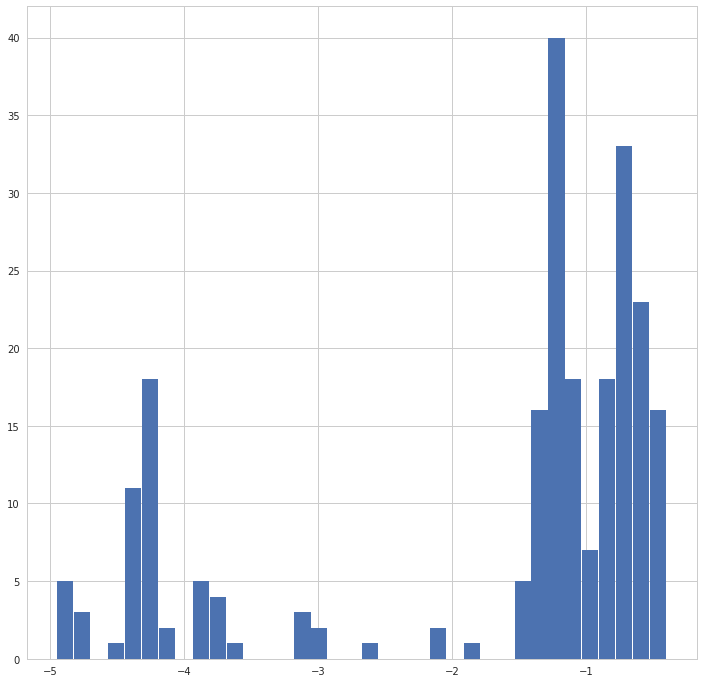

In [146]:
plt.hist(df["WP"], 36, rwidth=0.95)
np.std(df["WP"])

# Calculate Various Indices

In [11]:
df["YELLOW1"] = df["550"]
df["RED1"] = df["680"]
df["RED3"] = df["670"]
df["NIR1"] = df["800"]
df["NIR3"] = df["900"]
df["NIR4"] = df["970"]
df["NIR5"] = df["700"]

In [12]:
df["WBI"] = df["NIR4"] / df["NIR3"]
print(stats.pearsonr(df["WBI"], df["Chlorophyll"]), stats.pearsonr(df["WBI"], df["WP"]))
print(stats.pearsonr(df["WBI"], df["Average Height"]), stats.pearsonr(df["WBI"], df["Average Leaf Count"]))

(-0.59595725844047176, 5.4959837350701041e-24) (-0.049369457954738197, 0.45130366386338028)
(0.57007285075308201, 1.1837701727599572e-21) (0.62439482777607325, 8.3423660317184809e-27)


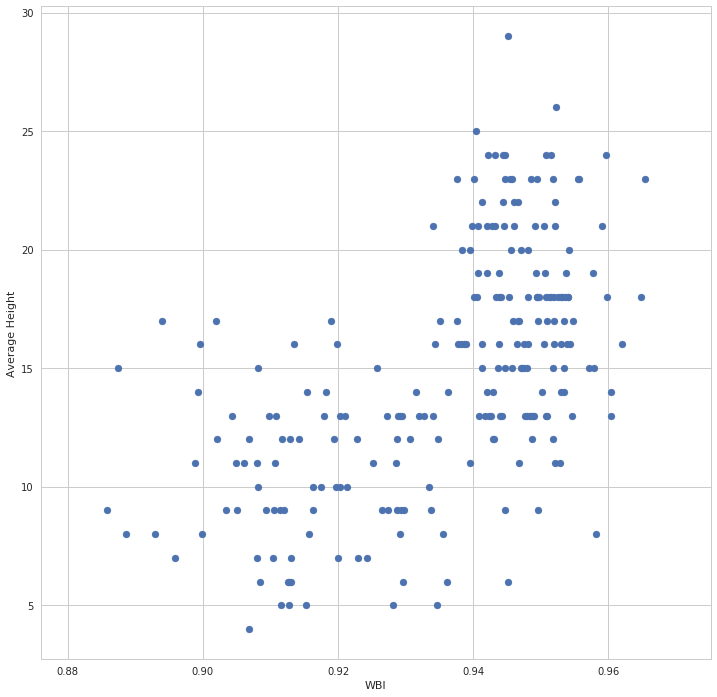

In [20]:
fig = plt.figure
plt.scatter(df["WBI"], df["Average Height"])
plt.xlabel("WBI")
plt.ylabel("Average Height")

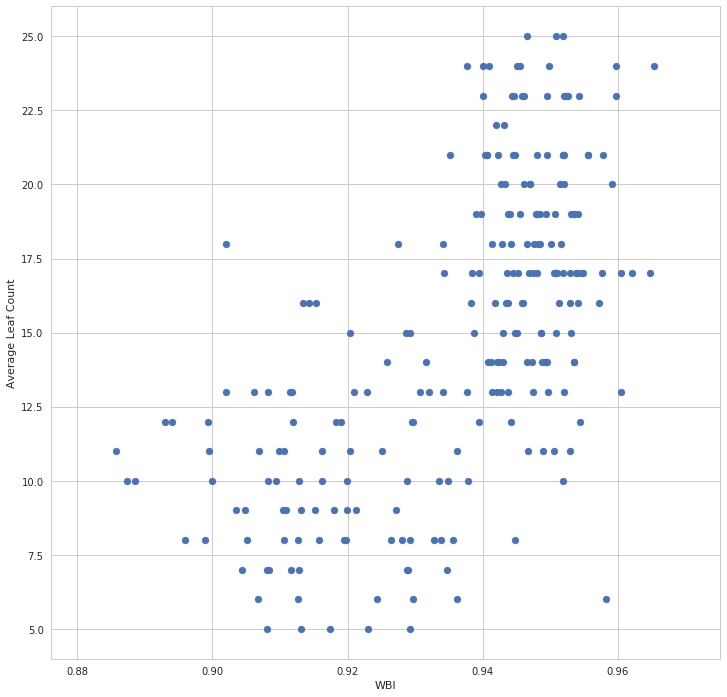

In [21]:
fig = plt.figure
plt.scatter(df["WBI"], df["Average Leaf Count"])
plt.xlabel("WBI")
plt.ylabel("Average Leaf Count")

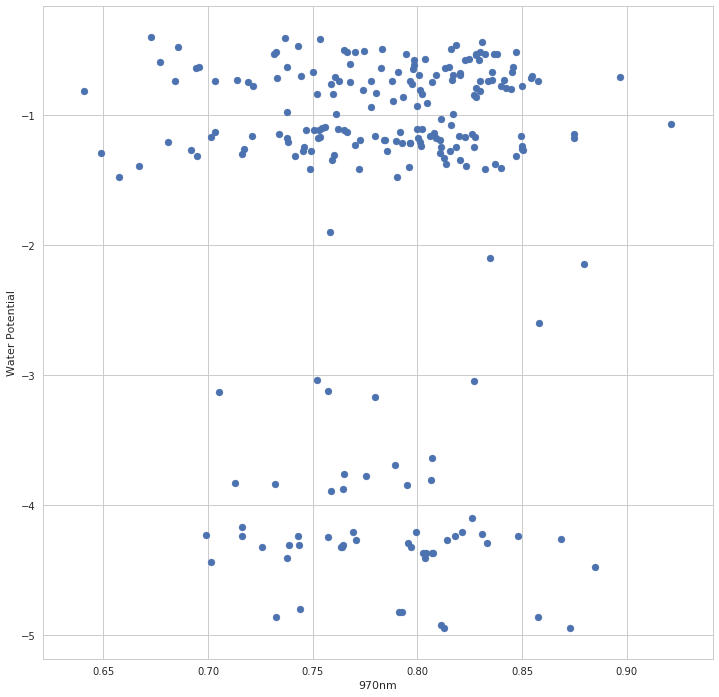

In [181]:
fig = plt.figure
plt.scatter(df["NIR4"].values, df["WP"])
plt.xlabel("970nm")
plt.ylabel("Water Potential")

In [182]:
print(stats.pearsonr(df["NDVI"], df["Chlorophyll"]), stats.pearsonr(df["NDVI"], df["WP"]))
print(stats.pearsonr(df["NDVI"], df["Average Height"]), stats.pearsonr(df["NDVI"], df["Average Leaf Count"]))

(-0.19925808877310214, 0.0021469290717437443) (-0.047320565004114142, 0.47032704042357854)
(0.31948327232376322, 5.6383382309188008e-07) (0.37154666197937486, 4.1760119228624161e-09)


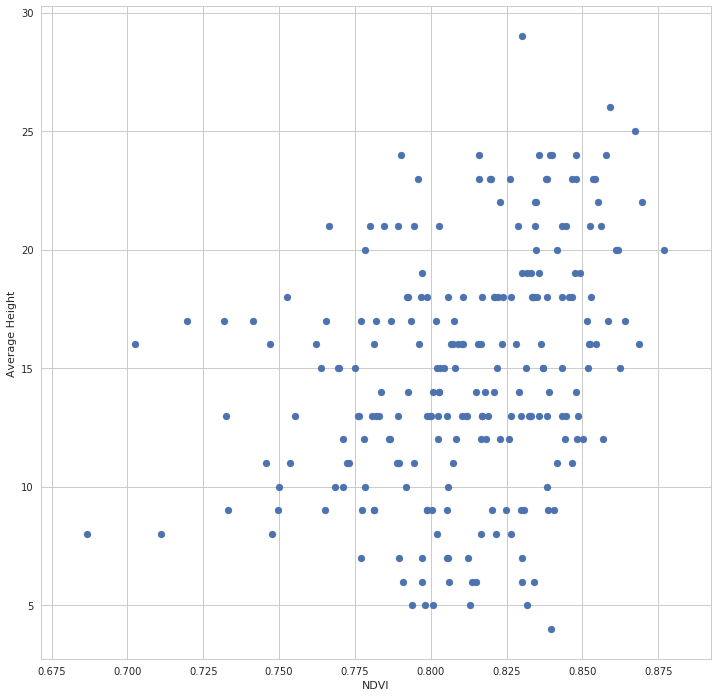

In [14]:
fig = plt.figure
plt.scatter(df["NDVI"].values, df["Average Height"])
plt.xlabel("NDVI")
plt.ylabel("Average Height")

In [17]:
df["rededge"] = df["NIR5"] / df["RED3"]
print(stats.pearsonr(df["rededge"], df["Chlorophyll"]), stats.pearsonr(df["rededge"], df["WP"]))
print(stats.pearsonr(df["rededge"], df["Average Height"]), stats.pearsonr(df["rededge"], df["Average Leaf Count"]))

(-0.40282782291435326, 1.3970601134162557e-10) (0.21337753710831597, 0.00099632029873528366)
(0.24264159393168758, 0.00017259785655103057) (0.1695929486100273, 0.0091916034909472078)


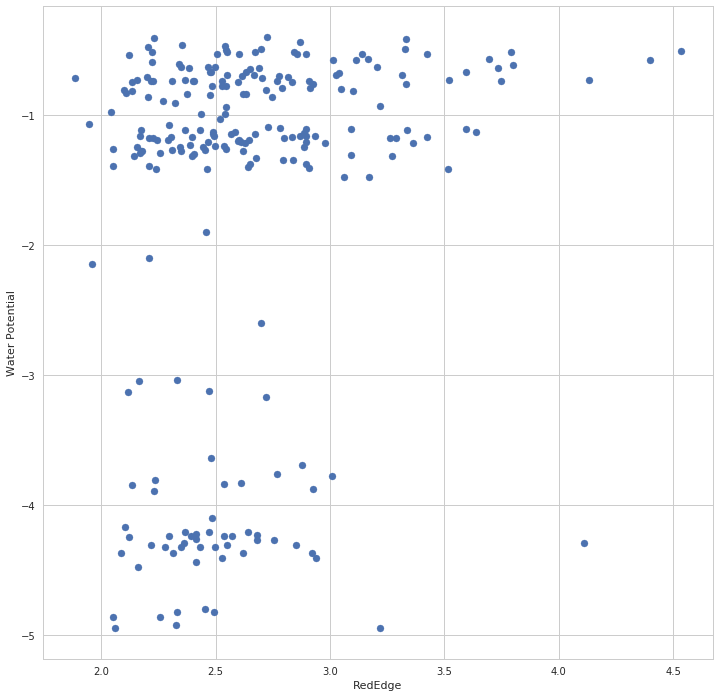

In [18]:
fig = plt.figure
plt.scatter(df["rededge"].values, df["WP"])
plt.xlabel("RedEdge")
plt.ylabel("Water Potential")

In [184]:
df["MCARI"] = (df["NIR5"] / df["RED3"]) - 0.23 * (df["NIR5"] - df["YELLOW1"]) * df["NIR5"] / df["RED3"]
print(stats.pearsonr(df["MCARI"], df["Chlorophyll"]), stats.pearsonr(df["MCARI"], df["WP"]))
print(stats.pearsonr(df["MCARI"], df["Average Height"]), stats.pearsonr(df["MCARI"], df["Average Leaf Count"]))

(-0.40051445989003859, 1.8185003774032157e-10) (0.21400210370387668, 0.00096194207196117207)
(0.24071975056738984, 0.00019499294968314203) (0.16764129552666371, 0.010040425611406096)


In [19]:
NIR = df["800"]
GREEN = df["550"]
df["GNDVI"] = (NIR - GREEN) / (NIR + GREEN)
print(stats.pearsonr(df["GNDVI"], df["Chlorophyll"]), stats.pearsonr(df["GNDVI"], df["WP"]))
print(stats.pearsonr(df["GNDVI"], df["Average Height"]), stats.pearsonr(df["GNDVI"], df["Average Leaf Count"]))

(-0.040404602502323264, 0.53767023834036198) (-0.18197457914364235, 0.0051397234148151064)
(0.27551928365142703, 1.832965045847816e-05) (0.38058020975688028, 1.6236388124856021e-09)


# Compare Indices to Treatments

In [186]:
print(df[df["Irrigation"] == 100]["WBI"].mean())
print(df[df["Irrigation"] == 50]["WBI"].mean())
print(df[df["Irrigation"] == 25]["WBI"].mean())
print(df[df["Irrigation"] == 0]["WBI"].mean())
print(df[df["Irrigation"] == 100]["NDVI"].mean())
print(df[df["Irrigation"] == 50]["NDVI"].mean())
print(df[df["Irrigation"] == 25]["NDVI"].mean())
print(df[df["Irrigation"] == 0]["NDVI"].mean())
print(df[df["Irrigation"] == 100]["rededge"].mean())
print(df[df["Irrigation"] == 50]["rededge"].mean())
print(df[df["Irrigation"] == 25]["rededge"].mean())
print(df[df["Irrigation"] == 0]["rededge"].mean())
print(df[df["Irrigation"] == 100]["MCARI"].mean())
print(df[df["Irrigation"] == 50]["MCARI"].mean())
print(df[df["Irrigation"] == 25]["MCARI"].mean())
print(df[df["Irrigation"] == 0]["MCARI"].mean())
print(df[df["Irrigation"] == 100]["GNDVI"].mean())
print(df[df["Irrigation"] == 50]["GNDVI"].mean())
print(df[df["Irrigation"] == 25]["GNDVI"].mean())
print(df[df["Irrigation"] == 0]["GNDVI"].mean())
print(df[df["Irrigation"] == 100]["Average Height"].mean())
print(df[df["Irrigation"] == 50]["Average Height"].mean())
print(df[df["Irrigation"] == 25]["Average Height"].mean())
print(df[df["Irrigation"] == 0]["Average Height"].mean())
print(df[df["Irrigation"] == 100]["Average Leaf Count"].mean())
print(df[df["Irrigation"] == 50]["Average Leaf Count"].mean())
print(df[df["Irrigation"] == 25]["Average Leaf Count"].mean())
print(df[df["Irrigation"] == 0]["Average Leaf Count"].mean())

0.936240782681
0.935189607241
0.934611378709
0.937421761658
0.807587002893
0.81217755508
0.811413770438
0.814516210225
2.83886121776
2.64249721172
2.58296335238
2.49733906991
2.83533726691
2.63936737095
2.58075935397
2.49467825433
0.634668977714
0.654809298483
0.656846727188
0.666926625266
17.35
14.7166666667
13.7333333333
13.1636363636
16.7
14.5666666667
13.75
14.0545454545


In [187]:
print(df[df["Nitrogen"] == 100]["WBI"].mean())
print(df[df["Nitrogen"] == 50]["WBI"].mean())
print(df[df["Nitrogen"] == 25]["WBI"].mean())
print(df[df["Nitrogen"] == 0]["WBI"].mean())
print(df[df["Nitrogen"] == 100]["NDVI"].mean())
print(df[df["Nitrogen"] == 50]["NDVI"].mean())
print(df[df["Nitrogen"] == 25]["NDVI"].mean())
print(df[df["Nitrogen"] == 0]["NDVI"].mean())
print(df[df["Nitrogen"] == 100]["rededge"].mean())
print(df[df["Nitrogen"] == 50]["rededge"].mean())
print(df[df["Nitrogen"] == 25]["rededge"].mean())
print(df[df["Nitrogen"] == 0]["rededge"].mean())
print(df[df["Nitrogen"] == 100]["MCARI"].mean())
print(df[df["Nitrogen"] == 50]["MCARI"].mean())
print(df[df["Nitrogen"] == 25]["MCARI"].mean())
print(df[df["Nitrogen"] == 0]["MCARI"].mean())
print(df[df["Nitrogen"] == 100]["GNDVI"].mean())
print(df[df["Nitrogen"] == 50]["GNDVI"].mean())
print(df[df["Nitrogen"] == 25]["GNDVI"].mean())
print(df[df["Nitrogen"] == 0]["GNDVI"].mean())
print(df[df["Nitrogen"] == 100]["Average Height"].mean())
print(df[df["Nitrogen"] == 50]["Average Height"].mean())
print(df[df["Nitrogen"] == 25]["Average Height"].mean())
print(df[df["Nitrogen"] == 0]["Average Height"].mean())
print(df[df["Nitrogen"] == 100]["Average Leaf Count"].mean())
print(df[df["Nitrogen"] == 50]["Average Leaf Count"].mean())
print(df[df["Nitrogen"] == 25]["Average Leaf Count"].mean())
print(df[df["Nitrogen"] == 0]["Average Leaf Count"].mean())

0.935366337015
0.936414268507
0.936333943425
0.935258329823
0.810741780503
0.813531937897
0.811376683549
0.809782509465
2.75188429924
2.56194392971
2.67982066391
2.58321875841
2.74857850157
2.55964100918
2.67711585656
2.58001001238
0.64552207194
0.66134195423
0.649721037116
0.655232766352
16.0333333333
14.3833333333
14.8363636364
13.85
13.8
15.1166666667
16.4727272727
13.8833333333


In [204]:
print(df[df["Irrigation"] == 100]["WBI"].max())
print(df[df["Irrigation"] == 50]["WBI"].max())
print(df[df["Irrigation"] == 25]["WBI"].max())
print(df[df["Irrigation"] == 0]["WBI"].max())
print(df[df["Irrigation"] == 100]["NDVI"].max())
print(df[df["Irrigation"] == 50]["NDVI"].max())
print(df[df["Irrigation"] == 25]["NDVI"].max())
print(df[df["Irrigation"] == 0]["NDVI"].max())
print(df[df["Irrigation"] == 100]["rededge"].max())
print(df[df["Irrigation"] == 50]["rededge"].max())
print(df[df["Irrigation"] == 25]["rededge"].max())
print(df[df["Irrigation"] == 0]["rededge"].max())
print(df[df["Irrigation"] == 100]["MCARI"].max())
print(df[df["Irrigation"] == 50]["MCARI"].max())
print(df[df["Irrigation"] == 25]["MCARI"].max())
print(df[df["Irrigation"] == 0]["MCARI"].max())
print(df[df["Irrigation"] == 100]["GNDVI"].max())
print(df[df["Irrigation"] == 50]["GNDVI"].max())
print(df[df["Irrigation"] == 25]["GNDVI"].max())
print(df[df["Irrigation"] == 0]["GNDVI"].max())

1.12685917802
1.12537209221
1.12895900967
1.1198559404
0.8609080855
0.8687967658
0.8584916766
0.876963167
4.53371693301
4.39858285102
3.59589621634
4.10939603462
4.5269535011
4.39375634511
3.59288264529
4.08268391278
0.742855508401
0.757710294151
0.75257390188
0.776875815093


In [205]:
print(df[df["Irrigation"] == 100]["WBI"].min())
print(df[df["Irrigation"] == 50]["WBI"].min())
print(df[df["Irrigation"] == 25]["WBI"].min())
print(df[df["Irrigation"] == 0]["WBI"].min())
print(df[df["Irrigation"] == 100]["NDVI"].min())
print(df[df["Irrigation"] == 50]["NDVI"].min())
print(df[df["Irrigation"] == 25]["NDVI"].min())
print(df[df["Irrigation"] == 0]["NDVI"].min())
print(df[df["Irrigation"] == 100]["rededge"].min())
print(df[df["Irrigation"] == 50]["rededge"].min())
print(df[df["Irrigation"] == 25]["rededge"].min())
print(df[df["Irrigation"] == 0]["rededge"].min())
print(df[df["Irrigation"] == 100]["MCARI"].min())
print(df[df["Irrigation"] == 50]["MCARI"].min())
print(df[df["Irrigation"] == 25]["MCARI"].min())
print(df[df["Irrigation"] == 0]["MCARI"].min())
print(df[df["Irrigation"] == 100]["GNDVI"].min())
print(df[df["Irrigation"] == 50]["GNDVI"].min())
print(df[df["Irrigation"] == 25]["GNDVI"].min())
print(df[df["Irrigation"] == 0]["GNDVI"].min())

1.03585063951
1.0364796099
1.04124746676
1.04039320403
0.702392599
0.697814
0.6867496237
0.724638
2.10084622831
1.88315683977
1.94829461758
1.98722788331
2.09900965035
1.87855006249
1.94482209967
1.98612250883
0.51964809922
0.502422501346
0.520071631541
0.516670698596


In [202]:
print(df[df["Nitrogen"] == 100]["WBI"].max())
print(df[df["Nitrogen"] == 50]["WBI"].max())
print(df[df["Nitrogen"] == 25]["WBI"].max())
print(df[df["Nitrogen"] == 0]["WBI"].max())
print(df[df["Nitrogen"] == 100]["NDVI"].max())
print(df[df["Nitrogen"] == 50]["NDVI"].max())
print(df[df["Nitrogen"] == 25]["NDVI"].max())
print(df[df["Nitrogen"] == 0]["NDVI"].max())
print(df[df["Nitrogen"] == 100]["rededge"].max())
print(df[df["Nitrogen"] == 50]["rededge"].max())
print(df[df["Nitrogen"] == 25]["rededge"].max())
print(df[df["Nitrogen"] == 0]["rededge"].max())
print(df[df["Nitrogen"] == 100]["MCARI"].max())
print(df[df["Nitrogen"] == 50]["MCARI"].max())
print(df[df["Nitrogen"] == 25]["MCARI"].max())
print(df[df["Nitrogen"] == 0]["MCARI"].max())
print(df[df["Nitrogen"] == 100]["GNDVI"].max())
print(df[df["Nitrogen"] == 50]["GNDVI"].max())
print(df[df["Nitrogen"] == 25]["GNDVI"].max())
print(df[df["Nitrogen"] == 0]["GNDVI"].max())

1.12685917802
1.12895900967
1.1198559404
1.12537209221
0.8672911981
0.876963167
0.8617238057
0.8687967658
4.53371693301
3.59504725827
4.39858285102
4.13293375173
4.5269535011
3.5942508167
4.39375634511
4.1187805496
0.769747530466
0.776875815093
0.74763727241
0.743207207979


In [203]:
print(df[df["Nitrogen"] == 100]["WBI"].min())
print(df[df["Nitrogen"] == 50]["WBI"].min())
print(df[df["Nitrogen"] == 25]["WBI"].min())
print(df[df["Nitrogen"] == 0]["WBI"].min())
print(df[df["Nitrogen"] == 100]["NDVI"].min())
print(df[df["Nitrogen"] == 50]["NDVI"].min())
print(df[df["Nitrogen"] == 25]["NDVI"].min())
print(df[df["Nitrogen"] == 0]["NDVI"].min())
print(df[df["Nitrogen"] == 100]["rededge"].min())
print(df[df["Nitrogen"] == 50]["rededge"].min())
print(df[df["Nitrogen"] == 25]["rededge"].min())
print(df[df["Nitrogen"] == 0]["rededge"].min())
print(df[df["Nitrogen"] == 100]["MCARI"].min())
print(df[df["Nitrogen"] == 50]["MCARI"].min())
print(df[df["Nitrogen"] == 25]["MCARI"].min())
print(df[df["Nitrogen"] == 0]["MCARI"].min())
print(df[df["Nitrogen"] == 100]["GNDVI"].min())
print(df[df["Nitrogen"] == 50]["GNDVI"].min())
print(df[df["Nitrogen"] == 25]["GNDVI"].min())
print(df[df["Nitrogen"] == 0]["GNDVI"].min())

1.03585063951
1.0419965457
1.03782450002
1.0364796099
0.724638
0.702392599
0.6867496237
0.697814
2.11622902365
1.88315683977
1.95979707636
2.05275605637
2.1150584636
1.87855006249
1.95434175792
2.04792433156
0.516670698596
0.537829302773
0.502422501346
0.510076971993
